In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import cftime
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import config
import util

In [3]:
catalog = util.curate_flux_products().open_catalog()
catalog

flux_products-catalog-local:
  args:
    path: catalogs/flux_products-catalog-local.yml
  description: Flux products for transport modeling
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [4]:
cat_keys = list(catalog._entries.keys())
catalog._entries

{'fgapo.carboscope.apo99_v2020': name: fgapo.carboscope.apo99_v2020
 container: xarray
 plugin: ['netcdf']
 driver: ['netcdf']
 description: APO fluxes from CarboScope inversion apo99_v2020
 direct_access: forbid
 user_parameters: []
 metadata: 
 args: 
   urlpath: /glade/work/mclong/sno-analysis/flux-products/fgapo_ocn.CarboScope.apo99_v2020.nc
   xarray_kwargs: 
     decode_times: False,
 'fgco2.MPI-SOM-FFN': name: fgco2.MPI-SOM-FFN
 container: xarray
 plugin: ['netcdf']
 driver: ['netcdf']
 description: An observation-based global monthly gridded sea surface pCO2 product from 1982 onward and its monthly climatology. Citation: Landschützer, P., Gruber, N., Bakker, D. C. E.: Decadal variations and trends of the global ocean carbon sink, Global Biogeochemical Cycles, 30, doi:10.1002/2015GB005359, 2016
 direct_access: forbid
 user_parameters: []
 metadata: 
 args: 
   urlpath: /glade/work/mclong/sno-analysis/flux-products/fgco2.MPI-SOM-FFN.v2018.monclim_2009-2018.nc
   xarray_kwargs: 
 

In [5]:
USER = os.environ['USER']
dirout = f'/glade/scratch/{USER}/sno-flux-products'
os.makedirs(dirout, exist_ok=True)

In [6]:
dso_grid = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]
dso_grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    area     (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08

In [7]:
cluster, client = util.get_ClusterClient()
cluster.scale(12)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:40019,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
def get_varname_from_key(key, dsi):
    varname = key.split('.')[0]    
    if varname not in dsi.data_vars:
        varname = f'{varname}_ocn'
    assert varname in dsi.data_vars        
    return varname

In [9]:
year_range = 1999, 2018

time_units = 'days since 1990-01-01 00:00:00'
daily_time, daily_time_bnds = util.gen_daily_cftime_coord(year_range)        


dsets = {}
for key in cat_keys:
    dsi = catalog[key].to_dask()    
    varname = get_varname_from_key(key, dsi)
    is_climatology = 'climatology' in dsi.time.attrs
    
    if is_climatology:
        file_out = f'{dirout}/{key}.1x1.repeat_monclim.{year_range[0]}0101-{year_range[1]}1231.nc' 
    else:
        file_out = f'{dirout}/{key}.1x1.{year_range[0]}0101-{year_range[1]}1231.nc' 
        
    
    # if it's a monthly climatology, repeat it for the period of interest ± 1 year
    if is_climatology:
        data = np.concatenate([dsi[varname].data for i in range(year_range[0] - 1, year_range[1] + 2)], axis=0)                
        var_attrs = dsi[varname].attrs
        monthly_time, monthly_time_bounds = util.gen_midmonth_cftime_coord([year_range[0] - 1, year_range[1] + 1])
        monthly_time_num = xr.DataArray(
            cftime.date2num(monthly_time, units=dsi.time.units),
            dims=('time'),
            attrs={'units': dsi.time.units, 'bounds': 'time_bnds'},
        )
        monthly_time_bounds_num = xr.DataArray(
            cftime.date2num(monthly_time_bounds, units=dsi.time.units),
            dims=('time', 'd2'),
        )        
        
        dims = dsi[varname].dims        
        dsi = dsi[[v for v in dsi.variables if 'time' not in dsi[v].dims]]
        
        dsi[varname] = xr.DataArray(data, dims=dims, 
                                    coords={'time': monthly_time_num},
                                    attrs=var_attrs,
                                    name=varname,                                    
                                   )
        dsi['time_bnds'] = monthly_time_bounds_num
        dsi['time'] = monthly_time_num
        
    
    daily_time, daily_time_bnds = util.gen_daily_cftime_coord(year_range)        
    daily_time_num_data = cftime.date2num(daily_time, units=dsi.time.units)
        
    # interpolate
    drop_list = [v for v in dsi.data_vars if 'time' in dsi[v].dims and v != varname]
    dsi_daily = dsi.drop(drop_list).interp(time=daily_time_num_data)

    dsi_daily['time'] = daily_time
    dsi_daily.time.encoding['units'] = time_units    
    dsi_daily[daily_time.bounds] = daily_time_bnds    
    
    dsi_daily['time_components'] = util.gen_time_components_variable(daily_time)

    for v in ['area', 'lat', 'lon']:
        dsi_daily[v] = dso_grid[v]
    
    assert dsi_daily[varname].attrs['units'] == 'mol/m^2/s'
        
    util.to_netcdf_clean(dsi_daily, file_out)
    dsets[key] = dsi_daily
    
dsi_daily

------------------------------
Writing /glade/scratch/mclong/sno-flux-products/fgapo.carboscope.apo99_v2020.1x1.19990101-20181231.nc
netcdf fgapo.carboscope.apo99_v2020.1x1.19990101-20181231 {
dimensions:
	lat = 180 ;
	lon = 360 ;
	time = 7305 ;
	d2 = 2 ;
	n_time_components = 6 ;
variables:
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	float fgapo_ocn(time, lat, lon) ;
		fgapo_ocn:_FillValue = 9.96921e+36f ;
		fgapo_ocn:long_name = "Ocean-atmosphere apo flux" ;
		fgapo_ocn:units = "mol/m^2/s" ;
		fgapo_ocn:cell_methods = "lon: lat: sum" ;
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1999-01-01" ;
		time:calendar = "gregorian" ;
	double time_bnds(time, d2) ;
	float time_components(time, n_time_components) ;
		time_components:_Fil

<xarray.Dataset>
Dimensions:          (lat: 180, lon: 360, time: 7305, d2: 2, n_time_components: 6)
Coordinates:
  * lat              (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time             (time) object 1999-01-01 12:00:00 ... 2018-12-31 12:00:00
Dimensions without coordinates: d2, n_time_components
Data variables:
    area             (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    fgo2             (time, lat, lon) float64 0.0 0.0 ... 3.042e-08 3.042e-08
    time_bnds        (time, d2) object 1999-01-01 00:00:00 ... 2019-01-01 00:...
    time_components  (time, n_time_components) float64 1.999e+03 1.0 ... 0.0 0.0
Attributes:
    history:  created by https://github.com/matt-long/sno-analysis/tree/2263d...

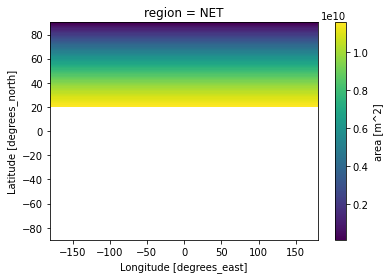

In [10]:
dsi = dsets[cat_keys[0]]

region = xr.DataArray(['NET', 'SET'], dims=('region'), name='region')
masked_area = xr.concat([
    dsi.area.where((dsi.lat >= 20)),
    dsi.area.where((dsi.lat <= -20)),    
],
    dim=region,
)
masked_area.isel(region=0).plot()

fgapo.carboscope.apo99_v2020
fgco2.MPI-SOM-FFN
fgco2.cesm_fosi_smyle
fgn2.cesm_fosi_smyle
fgn2.era5_shf
fgo2.cesm_fosi_smyle
fgo2.gk2001_Resplandy


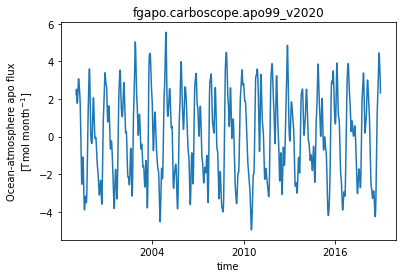

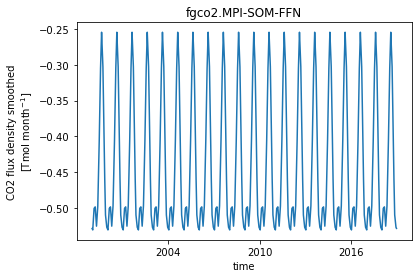

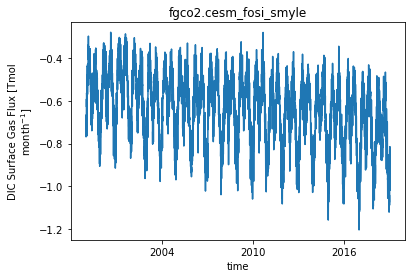

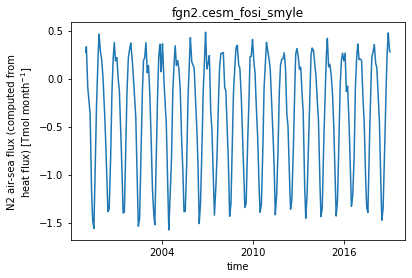

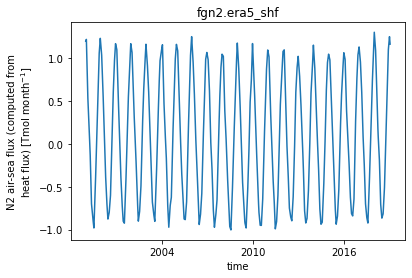

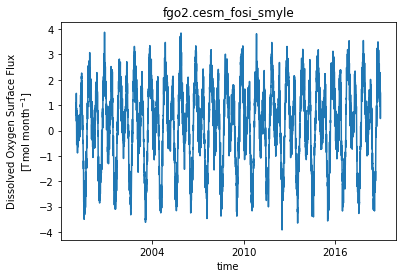

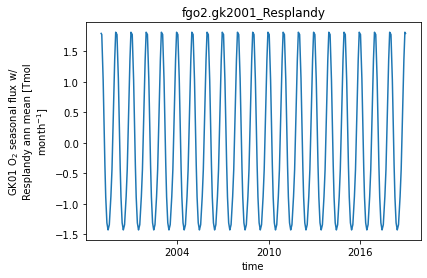

In [11]:
for key in cat_keys:
    print(key)
    
    dsi = dsets[key]
    v = get_varname_from_key(key, dsi)    
    assert dsi[v].units in ['mol/m^2/s']

    plt.figure()
    
    with xr.set_options(keep_attrs=True):    
        global_sum = ((dsi[v] * dsi.area).sum(['lat', 'lon'])) * 1e-12 * 86400.
        global_sum.attrs['units'] = 'Tmol day$^{-1}$'
        global_sum.attrs['units'] = 'Tmol month$^{-1}$'

    global_sum.plot()
    plt.title(key)


fgapo.carboscope.apo99_v2020
GLB fgapo.carboscope.apo99_v2020: 83.628992 Tmol/yr
NET fgapo.carboscope.apo99_v2020: -63.708 Tmol/yr
SET fgapo.carboscope.apo99_v2020: -62.442 Tmol/yr

fgco2.MPI-SOM-FFN
GLB fgco2.MPI-SOM-FFN: -160.994317 Tmol/yr
NET fgco2.MPI-SOM-FFN: -83.235 Tmol/yr
SET fgco2.MPI-SOM-FFN: -126.802 Tmol/yr

fgco2.cesm_fosi_smyle
GLB fgco2.cesm_fosi_smyle: -225.801496 Tmol/yr
NET fgco2.cesm_fosi_smyle: -114.888 Tmol/yr
SET fgco2.cesm_fosi_smyle: -125.997 Tmol/yr

fgn2.cesm_fosi_smyle
GLB fgn2.cesm_fosi_smyle: -127.333315 Tmol/yr
NET fgn2.cesm_fosi_smyle: -139.719 Tmol/yr
SET fgn2.cesm_fosi_smyle: -92.379 Tmol/yr

fgn2.era5_shf
GLB fgn2.era5_shf: 2.249544 Tmol/yr
NET fgn2.era5_shf: -96.599 Tmol/yr
SET fgn2.era5_shf: -10.205 Tmol/yr

fgo2.cesm_fosi_smyle
GLB fgo2.cesm_fosi_smyle: 139.546838 Tmol/yr
NET fgo2.cesm_fosi_smyle: -53.108 Tmol/yr
SET fgo2.cesm_fosi_smyle: -32.368 Tmol/yr

fgo2.gk2001_Resplandy
GLB fgo2.gk2001_Resplandy: 1.025335 Tmol/yr
NET fgo2.gk2001_Resplandy: -

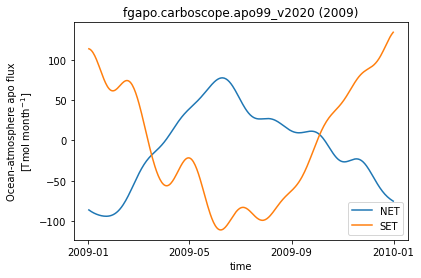

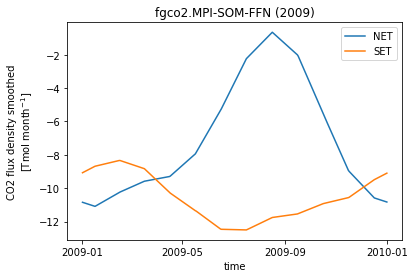

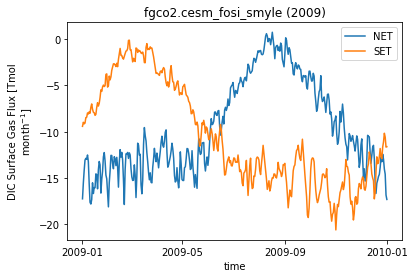

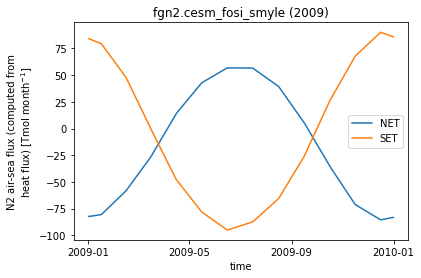

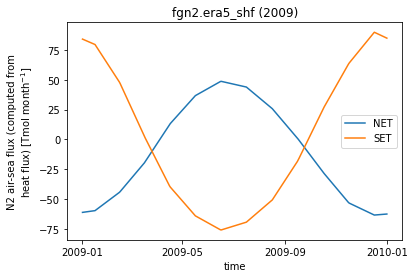

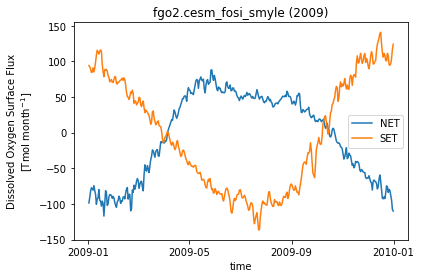

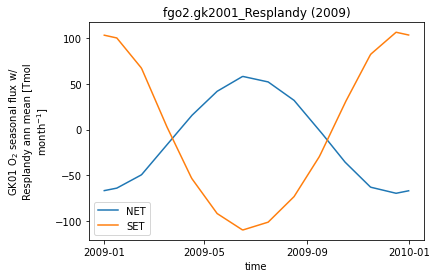

In [12]:
sel_year = '2009'

region = xr.DataArray(['NET', 'SET'], dims=('region'), name='region')

for key in cat_keys:
    print(key)
    
    dsi = dsets[key].sel(time=sel_year)
    v = get_varname_from_key(key, dsi)    
    assert dsi[v].units in ['mol/m^2/s']
    
    masked_area = xr.concat([
        dsi.area.where((dsi.lat >= 20)),
        dsi.area.where((dsi.lat <= -20)),    
    ],
        dim=region,
    )    
    
    plt.figure()
    
    global_sum = ((dsi[v] * dsi.area).sum(['lat', 'lon'])).sum('time').values * 1e-12 * 86400.
    print(f'GLB {key}: {global_sum:03f} Tmol/yr')
    
    with xr.set_options(keep_attrs=True):
        dsi_region = (dsi[[v]] * masked_area).sum(['lat', 'lon']) * 1e-12 * 86400.
        dsi_region[v].attrs['units'] = 'Tmol day$^{-1}$'
        dsi_mon = dsi_region * 365. / 12.
        dsi_mon[v].attrs['units'] = 'Tmol month$^{-1}$'
    
    for region_name in dsi_region.region.values:   
        da = dsi_region[v].sel(region=region_name, drop=True)        
        regional_sum = da.sum('time').values
        da_mon = dsi_mon[v].sel(region=region_name, drop=True)     
        
        #da.plot(label=region_name)
        da_mon.plot(label=region_name)
        print(f'{region_name} {key}: {regional_sum:0.3f} Tmol/yr')        
    
    plt.title(f'{key} ({sel_year})')
    plt.legend();
    print()

fgn2.cesm_fosi_smyle
GLB fgn2.cesm_fosi_smyle: -127.3333 Tmol/yr
TRP fgn2.cesm_fosi_smyle: 104.7641 Tmol/yr
NET fgn2.cesm_fosi_smyle: -139.7187 Tmol/yr
SET fgn2.cesm_fosi_smyle: -92.3787 Tmol/yr

fgn2.era5_shf
GLB fgn2.era5_shf: 2.2495 Tmol/yr
TRP fgn2.era5_shf: 109.0538 Tmol/yr
NET fgn2.era5_shf: -96.5990 Tmol/yr
SET fgn2.era5_shf: -10.2052 Tmol/yr

fgo2.cesm_fosi_smyle
GLB fgo2.cesm_fosi_smyle: 139.5468 Tmol/yr
TRP fgo2.cesm_fosi_smyle: 225.0236 Tmol/yr
NET fgo2.cesm_fosi_smyle: -53.1084 Tmol/yr
SET fgo2.cesm_fosi_smyle: -32.3683 Tmol/yr

fgo2.gk2001_Resplandy
GLB fgo2.gk2001_Resplandy: 1.0253 Tmol/yr
TRP fgo2.gk2001_Resplandy: 174.2693 Tmol/yr
NET fgo2.gk2001_Resplandy: -99.9784 Tmol/yr
SET fgo2.gk2001_Resplandy: -73.2655 Tmol/yr



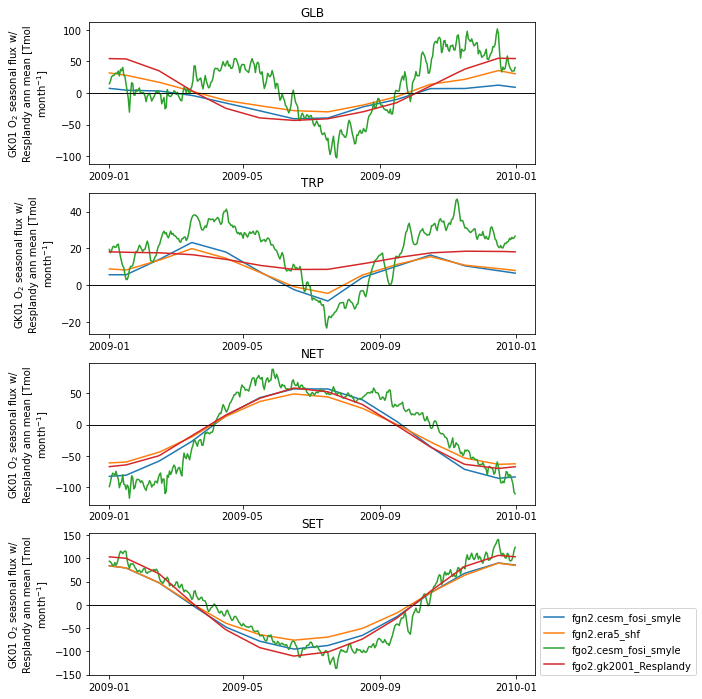

In [20]:
sel_year = '2009'

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

totals = {}
for key in cat_keys:
    if 'fgn2' not in key and 'fgo2' not in key:
        continue
    print(key)
    totals[key] = []
    
    dsi = dsets[key].sel(time=sel_year)
    v = get_varname_from_key(key, dsi)    
    assert dsi[v].units in ['mol/m^2/s']
    
    masked_area = xr.concat([
        dsi.area,        
        dsi.area.where((dsi.lat < 20) & (dsi.lat > -20)),        
        dsi.area.where((dsi.lat >= 20)),
        dsi.area.where((dsi.lat <= -20)),    
    ],
        dim=xr.DataArray(['GLB', 'TRP', 'NET', 'SET'], dims=('region'), name='region'),
    )    
        
    
    with xr.set_options(keep_attrs=True):
        dsi_region = (dsi[[v]] * masked_area).sum(['lat', 'lon']) * 1e-12 * 86400.
        dsi_region[v].attrs['units'] = 'Tmol day$^{-1}$'
        dsi_mon = dsi_region * 365. / 12.
        dsi_mon[v].attrs['units'] = 'Tmol month$^{-1}$'
    
    for i, region_name in enumerate(dsi_region.region.values):
        
        da = dsi_region[v].sel(region=region_name, drop=True)        
        regional_sum = da.sum('time').values
        da_mon = dsi_mon[v].sel(region=region_name, drop=True)     
        
        print(f'{region_name} {key}: {regional_sum:0.4f} Tmol/yr')        
        
        totals[key].append(float(regional_sum))
        
        
        #da.plot(label=key, ax=axs[i])
        da_mon.plot(label=f"{key}", ax=axs[i])
        axs[i].set_title(region_name)
        axs[i].set_xlabel('')
        axs[i].axhline(0, color='k', linewidth=0.5)
        
    plt.legend(loc=(1.01, 0));
    print()

-127.33331482224273
-127.33331482224266

2.249543921662074
2.249543921662095



Text(0, 0.5, 'Annual flux [Tmol/yr]')

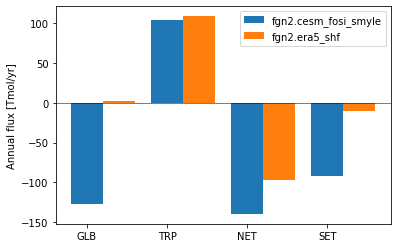

In [14]:
dx = 0
for key, values in totals.items():
    print(values[0])
    print(sum(values[1:]))
    print()
    plt.bar(np.arange(0, 4)+dx, values, width=0.4, label=key)
    dx = 0.4

plt.axhline(0, color='k', linewidth=0.5)
plt.xticks([0, 1, 2, 3], labels=['GLB', 'TRP', 'NET', 'SET']);
plt.legend();
plt.ylabel('Annual flux [Tmol/yr]')

In [15]:
totals

{'fgn2.cesm_fosi_smyle': [-127.33331482224273,
  104.76410799339301,
  -139.71871238401678,
  -92.37871043161888],
 'fgn2.era5_shf': [2.249543921662074,
  109.05379011470922,
  -96.59902374411621,
  -10.205222448930911]}

In [16]:
client.close()
cluster.close()